In [ ]:
!pip install pgmpy pandas numpy matplotlib seaborn scikit-learn

  Using cached pgmpy-1.0.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached pyro_ppl-1.9.1-py3-none-any.whl.metadata (7.8 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached pgmpy-1.0.0-py3-none-any.whl (2.0 MB)
Using cached pyro_ppl-1.9.1-py3-none-any.whl (755 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (13.8 MB)
Using cach

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import pgmpy

try:
    from pgmpy.models import DiscreteBayesianNetwork
    from pgmpy.estimators import MaximumLikelihoodEstimator
    from pgmpy.inference import VariableElimination
    from pgmpy.factors.discrete import TabularCPD
except ImportError:
    from pgmpy.models import BayesianModel as DiscreteBayesianNetwork
    from pgmpy.estimators import MaximumLikelihoodEstimator
    from pgmpy.inference import VariableElimination
    from pgmpy.factors.discrete import TabularCPD

In [56]:
url = "/content/heart_disease.csv"
try:
    df = pd.read_csv(url)
except:
    np.random.seed(42)
    n_samples = 1000
    df = pd.DataFrame({
        'age': np.random.randint(20, 80, n_samples),
        'sex': np.random.randint(0, 2, n_samples),
        'cp': np.random.randint(0, 4, n_samples),
        'trestbps': np.random.randint(90, 200, n_samples),
        'chol': np.random.randint(100, 400, n_samples),
        'fbs': np.random.randint(0, 2, n_samples),
        'restecg': np.random.randint(0, 3, n_samples),
        'thalach': np.random.randint(60, 220, n_samples),
        'exang': np.random.randint(0, 2, n_samples),
        'oldpeak': np.random.uniform(0, 6, n_samples),
        'slope': np.random.randint(0, 3, n_samples),
        'ca': np.random.randint(0, 4, n_samples),
        'thal': np.random.randint(0, 4, n_samples),
        'target': np.random.randint(0, 2, n_samples)
    })


In [59]:
df = df.drop_duplicates()
df = df.dropna()

In [58]:
scaler = MinMaxScaler()
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
df_normalized = df.copy()
df_normalized[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [60]:
def discretize_column(series, bins=3, labels=None):
    if labels is None:
        labels = ['Low', 'Medium', 'High']
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

df_discrete = df_normalized.copy()
df_discrete['age_cat'] = discretize_column(df_discrete['age'], labels=['Young', 'Middle', 'Old'])
df_discrete['chol_cat'] = discretize_column(df_discrete['chol'])
df_discrete['thalach_cat'] = discretize_column(df_discrete['thalach'])

for col in ['age_cat', 'chol_cat', 'thalach_cat', 'fbs', 'target']:
    df_discrete[col] = df_discrete[col].astype(str)

In [61]:
edges = [
    ('age_cat', 'fbs'),
    ('fbs', 'target'),
    ('target', 'chol_cat'),
    ('target', 'thalach_cat')
]

model = DiscreteBayesianNetwork(edges)
model.fit(df_discrete[['age_cat', 'fbs', 'target', 'chol_cat', 'thalach_cat']],
          estimator=MaximumLikelihoodEstimator)

In [63]:
inference = VariableElimination(model)

# Age-wise inference
for age_cat in ['Young', 'Middle', 'Old']:
    prob = inference.query(variables=['target'], evidence={'age_cat': age_cat})
    print(f"Age {age_cat}: P(Heart Disease=1) = {prob.values[1]:.3f}")

# FBS-wise inference (using '0.0' and '1.0' as state names)
for fbs in ['0.0', '1.0']:
    prob = inference.query(variables=['target'], evidence={'fbs': fbs})
    label = "Normal" if fbs == '0.0' else "High"
    print(f"FBS {label}: P(Heart Disease=1) = {prob.values[1]:.3f}")

# Cholesterol given heart disease
prob = inference.query(variables=['chol_cat'], evidence={'target': '1.0'})
for i, level in enumerate(['Low', 'Medium', 'High']):
    print(f"Cholesterol={level}: {prob.values[i]:.3f}")

# Thalach given heart disease
prob = inference.query(variables=['thalach_cat'], evidence={'target': '1.0'})
for i, level in enumerate(['Low', 'Medium', 'High']):
    print(f"Thalach={level}: {prob.values[i]:.3f}")

Age Young: P(Heart Disease=1) = 0.547
Age Middle: P(Heart Disease=1) = 0.542
Age Old: P(Heart Disease=1) = 0.542
FBS Normal: P(Heart Disease=1) = 0.549
FBS High: P(Heart Disease=1) = 0.511
Cholesterol=Low: 0.006
Cholesterol=Medium: 0.793
Cholesterol=High: 0.201
Thalach=Low: 0.561
Thalach=Medium: 0.024
Thalach=High: 0.415


In [64]:
total_samples = len(df_discrete)
heart_disease_rate = (df_discrete['target'] == '1.0').sum() / total_samples

print(f"Total samples: {total_samples}")
print(f"Heart disease rate: {heart_disease_rate:.3f} ({heart_disease_rate*100:.1f}%)")

print(f"Nodes in Network: {len(model.nodes())}")
print(f"Edges in Network: {len(model.edges())}")
print(f"CPDs valid: {model.check_model()}")

Total samples: 302
Heart disease rate: 0.543 (54.3%)
Nodes in Network: 5
Edges in Network: 4
CPDs valid: True


In [65]:
df_discrete.to_csv('cleaned_heart_disease_data.csv', index=False)

In [66]:
scenarios = [
    {'age_cat': 'Young', 'fbs': '0.0', 'description': 'Young, normal blood sugar'},
    {'age_cat': 'Old', 'fbs': '1.0', 'description': 'Old, high blood sugar'},
    {'age_cat': 'Middle', 'fbs': '0.0', 'description': 'Middle-aged, normal blood sugar'}
]

for i, scenario in enumerate(scenarios, 1):
    evidence = {k: v for k, v in scenario.items() if k != 'description'}
    prob = inference.query(variables=['target'], evidence=evidence)
    risk_prob = prob.values[1]
    risk_level = "HIGH" if risk_prob > 0.6 else "MEDIUM" if risk_prob > 0.4 else "LOW"
    print(f"\n{i}. {scenario['description']}")
    print(f"   Heart Disease Probability: {risk_prob:.3f}")
    print(f"   Risk Level: {risk_level}")


1. Young, normal blood sugar
   Heart Disease Probability: 0.549
   Risk Level: MEDIUM

2. Old, high blood sugar
   Heart Disease Probability: 0.511
   Risk Level: MEDIUM

3. Middle-aged, normal blood sugar
   Heart Disease Probability: 0.549
   Risk Level: MEDIUM


##Visualizations of the Bayesian Network or inference results


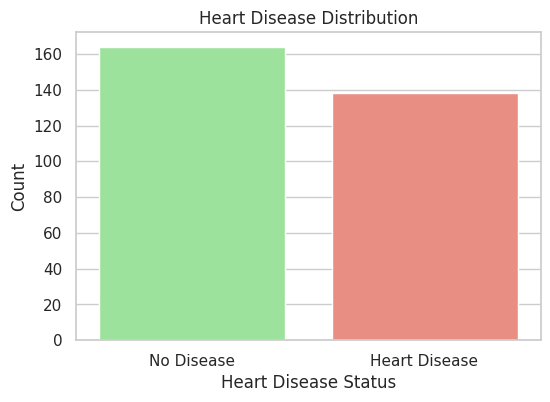

In [74]:
#Heart Disease Distribution (Target Variable)
import seaborn as sns

sns.set(style='whitegrid')
plt.figure(figsize=(6, 4))
sns.countplot(data=df_discrete, x='target', palette=['lightgreen', 'salmon'])
plt.title("Heart Disease Distribution")
plt.xticks([0, 1], ['No Disease', 'Heart Disease'])
plt.ylabel("Count")
plt.xlabel("Heart Disease Status")
plt.show()

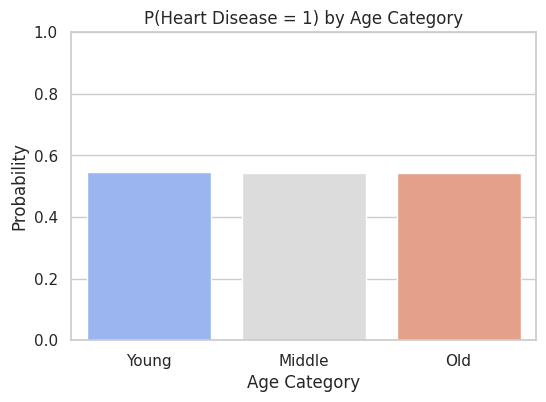

In [75]:
#Age Category vs Heart Disease Probability(Inference)
age_probs = {}
for age_cat in ['Young', 'Middle', 'Old']:
    q = inference.query(variables=['target'], evidence={'age_cat': age_cat})
    age_probs[age_cat] = q.values[1]

plt.figure(figsize=(6, 4))
sns.barplot(x=list(age_probs.keys()), y=list(age_probs.values()), palette="coolwarm")
plt.title("P(Heart Disease = 1) by Age Category")
plt.ylabel("Probability")
plt.xlabel("Age Category")
plt.ylim(0, 1)
plt.show()

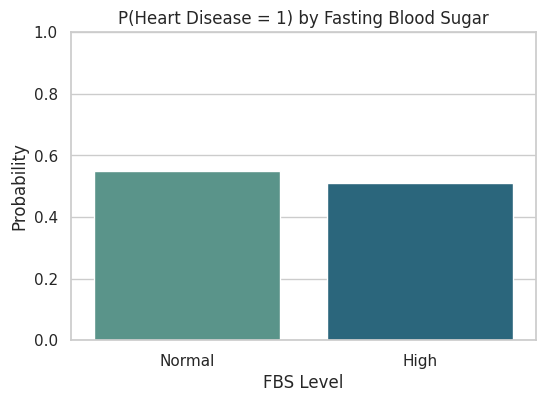

In [76]:
#Fasting Blood Sugar vs Heart Disease Probability
fbs_probs = {}
for fbs in ['0.0', '1.0']:
    q = inference.query(variables=['target'], evidence={'fbs': fbs})
    label = "Normal" if fbs == '0.0' else "High"
    fbs_probs[label] = q.values[1]

plt.figure(figsize=(6, 4))
sns.barplot(x=list(fbs_probs.keys()), y=list(fbs_probs.values()), palette="crest")
plt.title("P(Heart Disease = 1) by Fasting Blood Sugar")
plt.ylabel("Probability")
plt.xlabel("FBS Level")
plt.ylim(0, 1)
plt.show()

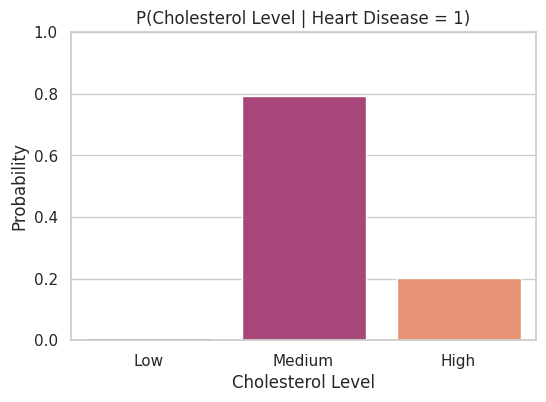

In [77]:
#Cholesterol Distribution given Heart Disease
chol_q = inference.query(variables=['chol_cat'], evidence={'target': '1.0'})
chol_values = [chol_q.values[i] for i in range(len(chol_q.values))]
labels = ['Low', 'Medium', 'High']

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=chol_values, palette="magma")
plt.title("P(Cholesterol Level | Heart Disease = 1)")
plt.ylabel("Probability")
plt.xlabel("Cholesterol Level")
plt.ylim(0, 1)
plt.show()

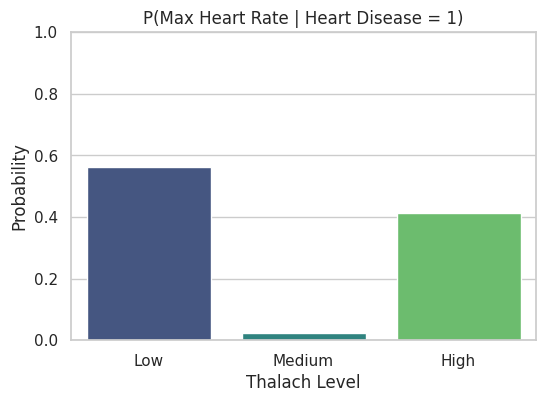

In [73]:
#Thalach Distribution given Heart Disease
thalach_q = inference.query(variables=['thalach_cat'], evidence={'target': '1.0'})
thalach_values = [thalach_q.values[i] for i in range(len(thalach_q.values))]
labels = ['Low', 'Medium', 'High']

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=thalach_values, palette="viridis")
plt.title("P(Max Heart Rate | Heart Disease = 1)")
plt.ylabel("Probability")
plt.xlabel("Thalach Level")
plt.ylim(0, 1)
plt.show()